In [1]:
import sys
sys.path.insert(0, '../../../')

import pandas as pd
from preprocess import Audio_Processor
from sklearn import metrics
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import numpy as np
from data_utils import enumerate_strings
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 16000

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
path_to_db='../../../../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/', sr=SR)
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 1,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

In [5]:
block_tries = {
    "blocksize": [int(SR/4), int(SR/2), int(SR), int(SR * 2), int(SR * 5)],
    "overlap": [int(SR/8), int(SR/4), int(SR/2), int(SR), 0]
              }

In [6]:
scores = []
for i in range(len(block_tries['blocksize'])):
    df = ps.preprocess_fold(dataset,
                           kind='mfcc',
                           blocksize=block_tries['blocksize'][i],
                           overlap=block_tries['overlap'][i])

    X = df.drop(['target', 'h_target'], axis=1)
    y = df['h_target']
    clf = make_pipeline(
        MinMaxScaler(),
        RandomForestClassifier()
    )
    scores.append(
        pd.DataFrame(
            RandomizedSearchCV(
                clf, 
                X, y,
                scoring=['accuracy', 'f1', 'recall', 'precision', 'roc_auc'], 
                cv=10,
                param_distributions = dists)
        ).cv_results_
    )
    scores[-1]['blocksize'] = block_tries['blocksize'][i]

In [7]:
res_df = pd.concat(scores, ignore_index=True)

In [8]:
res_df.groupby(['blocksize']).mean()

,fit_time,score_time,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc,train_accuracy,train_f1,train_precision,train_recall,train_roc_auc
blocksize,,,,,,,,,,,,
4000,0.125239,0.012788,0.7240,0.786319,0.777422,0.796875,0.763243,0.992167,0.993872,0.995129,0.992622,0.999557
8000,0.130515,0.012582,0.7075,0.773430,0.767656,0.779687,0.743462,0.990889,0.992875,0.993917,0.991840,0.999467
16000,0.144610,0.016284,0.6850,0.755461,0.751195,0.760938,0.718126,0.992222,0.993914,0.995304,0.992535,0.999496
32000,0.137483,0.013491,0.6800,0.750672,0.748666,0.753125,0.720530,0.990889,0.992873,0.994085,0.991667,0.999360
80000,0.114103,0.011255,0.6755,0.747649,0.745104,0.750781,0.706928,0.987833,0.990489,0.991228,0.989757,0.999020


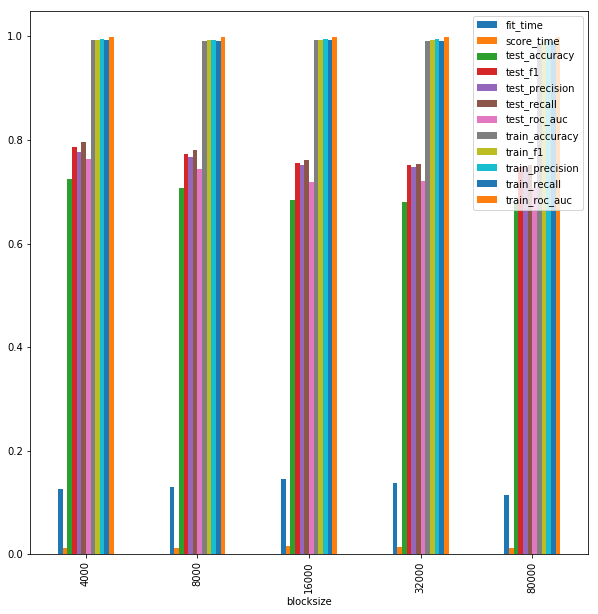

In [9]:
res_df.groupby(['blocksize']).mean().plot(figsize=(10,10), kind='bar')